# Alura - Imersão de Dados - Aula 4

<p>Nessa aula será utilizado o DataSet de imóveis de São Paulo, obtido do Kaggle, e iremos tentar resolver alguns problemas:</p>

<ol>
    <li>Realizar uma análise dos dados do IBGE por mapa, olhando para a distribuição de renda; </li>
    <li>Repassar a aula para entender melhor o que foi realizado; </li>
    <li>Aprofundar a análise entre dados de vendas e renda; </li>
    <li>Realizar a análise exploratória e encontrar variáveis relevantes para solução do problema;</li>
</ol>

## Declaração de importações

In [1]:
#!pip install geopandas

In [2]:
#Importando bibliotecas importantes
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
#sns.set(style = "white")
from colorsys import hls_to_rgb #Para cores!
from scipy import stats #Para tratamento os outliers que irão aparecer.
from shapely.geometry import Point   #Para uso da latitude e longitude.
from shapely.geometry import Polygon #Para uso da latitude e longitude.
import geopandas as gpd              #Para uso da latitude e longitude.

## Declaração de funções

In [80]:
def retornoDesc(INDEX,LISTA_NULOS,DF_RETORNO,COLUNA):
    """
    A sintaxe dessa função é: retornoDesc(INDEX, LISTA_NULOS, DF_RETORNO, COLUNA)
    Essa função irá retornar o valor "DESCONHECIDO" para colunas que contenham um valor NaN.
    INDEX é uma lista dos índices do dataframe.
    LISTA_NULOS é uma lista TRUE/FALSE contendo informações a respeito da existência ou não de um NaN.
    DF_RETORNO é o dataframe que estaremos fazendo modificações
    COLUNA é a coluna em que estaremos fazendo modificações.
    """
    for i in INDEX:
        if LISTA_NULOS[i]:
            DF_RETORNO[COLUNA].loc[i] = "Desconhecido"
    return DF_RETORNO

def bairros_ruins(DATASET,AGRUPAMENTO="Bairro",CONTAGEM="Metragem",CASAS=3):
    """
    A sintaxe da função é: bairros_ruins(DATASET, AGRUPAMENTO, CONTAGEM, CASAS=3)
    Essa função irá criar um lista para salvar os bairros que tenham um número menor de casas do que 
    é especificado para a função e irá retornar essa lista. 
    O DATASET será responsável por carregar o dataframe que será analisado. 
    O BAIRRO será responsável pelo agrupamento dos bairros.
    A CONTAGEM será o termo utilizado para que a contagem do número de casas seja feita. 
    Por fim, CASAS é o número de "corte" para algo ser salvo na lista.
    """
    lista_retorno = []
    for i in DATASET.groupby([AGRUPAMENTO]).count()[CONTAGEM].index:
        val = DATASET.groupby([AGRUPAMENTO]).count()[CONTAGEM].loc[i]
        if val <=CASAS:
            lista_retorno.append(i)
    return lista_retorno

def tukeys_method(df, variable):
    """
    Essa função é o método de Tukey para a detecção de Outliers. Ela separa os dados, que seriam vistos em
    um boxplot, em dados dentro de uma certa "zona", eles serão separados em dados que podem ser outliers
    (que fica entre a zona interna e a zona externa) e dados que provavelmente são outliers (que ficam
    localizados após a zona externa)
    Sua sintaxe é: tukeys_method(df,variable)
    Onde "df" é o dataframe.
    "variable" é a variável/coluna que queremos observar a existência de outliers. 
    """
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = 1.5*iqr
    outer_fence = 3*iqr
    
    #inner fence lower and upper end
    inner_fence_le = q1-inner_fence
    inner_fence_ue = q3+inner_fence
    
    #outer fence lower and upper end
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence
    
    outliers_prob = []
    outliers_poss = []
    for index, x in enumerate(df[variable]):
        if x <= outer_fence_le or x >= outer_fence_ue:
            outliers_prob.append(index)
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_poss.append(index)
    return outliers_prob, outliers_poss

#Uma função para fazer gráficos em barras. Aqui ela apenas faz com que os valores de cada barra sejam 
#postos em cima de sua respectiva barra. Qualquer outra alteração extra no gráfico deve ser feita de
#maneira separada.
def grap_retorno(VAL_X,VAL_Y,ARG_FONTE=20,ARG1_COR=0.2,ARG2_COR=1,RAN1=20,RAN2=30):
    cor = [(hls_to_rgb(i/(4*len(VAL_Y)),ARG1_COR,ARG2_COR)) for i in range(RAN1,RAN2)]
    ax = plt.bar(VAL_X,VAL_Y, color=cor)
    for val in ax:
        alt = val.get_height()
        plt.text(val.get_x() + val.get_width() / 2.0 ,alt,f'{alt: .0f}',ha="center",va="bottom", fontsize=ARG_FONTE)
    return ax 

In [4]:
#Caminho dos dados
path_dados_vendas = 'https://gist.githubusercontent.com/tgcsantos/3bdb29eba6ce391e90df2b72205ba891/raw/22fa920e80c9fa209a9fccc8b52d74cc95d1599b/dados_imoveis.csv'
DF_vendas_or = pd.read_csv(path_dados_vendas) #Leio o arquivo CSV
DF_vendas_or

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,R$ 685.000
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$ 540.000
...,...,...,...,...,...,...,...,...
10003,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,R$ 665.000
10004,Rua Guararema,Bosque da Saúde,São Paulo,605,8,7,5,R$ 2.300.000
10005,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,R$ 1.050.000
10006,"Rua Manuel Onha, , 514",Vila Oratório,São Paulo,185,3,2,2,R$ 2.200\n /Mês


In [5]:
#Carregando e limpando os dados do IBGE
path_ibge_sp = 'https://gist.githubusercontent.com/tgcsantos/85f8c7b0a2edbc3e27fcad619b37d886/raw/a4954781e6bca9cb804062a3eea0b3b84679daf4/Basico_SP1.csv'
DF_IBGE_or = pd.read_csv(path_ibge_sp, sep=";", decimal=",", thousands=".", encoding="UTF-8")
DF_IBGE_or.replace('�','ã', regex=True, inplace=True)
dicionario_distrito_IBGE = {
    "ãGUA RASA":"ÁGUA RASA", "BELãM":"BELÉM", "BRãS":"BRÁS", "BRASILãNDIA":"BRASILÁNDIA",
    "BUTANTã":"BUTANTÃ","CAPãO REDONDO":"CAPÃO REDONDO","CARRãO":"CARRÃO","CONSOLAããO":"CONSOLAÇÃO",
    "FREGUESIA DO ã":"FREGUESIA DO Ó","GRAJAã":"GRAJAU","JAãANã":"JAÇANÃ","JAGUARã":"JAGUARÉ",
    "JARAGUã":"JARAGUÁ", "JARDIM ãNGELA":"JARDIM ÂNGELA","JARDIM SãO LUãS":"JARDIM SÃO LUÍS",
    "JOSã BONIFãCIO":"JOSÉ BONIFÁCIO", "LIMãO":"LIMÃO", "REPãBLICA":"REPÚBLICA", "SACOMã":"SACOMÃ",
    "SANTA CECãLIA":"SANTA CECÍLIA", "SãO LUCAS":"SÃO LUCAS", "SãO MATEUS":"SÃO MATEUS", 
    "SãO MIGUEL":"SÃO MIGUEL", "SãO RAFAEL":"SÃO RAFAEL", "SAãDE":"SAÚDE", "Sã":"SÉ","TATUAPã":"TATUAPÉ",
    "TREMEMBã":"TREMEMBÉ", "VILA CURUãã":"VILA CURUÇÁ", "VILA JACUã":"VILA JACUÍ", "VILA SãNIA":"VILA SÔNIA",
    "SãO DOMINGOS":"SÃO DOMINGOS"
}
DF_IBGE_or["Nome_do_distrito"].replace(dicionario_distrito_IBGE, inplace = True)
DF_IBGE_or.drop(["Cod_UF","Nome_Grande_Regiao","Cod_Grandes Regi�es","Cod_meso"
                ,"Nome_da_meso","Cod_micro","Nome_da_micro","Nome_da_RM","Cod_RM"
                ,"Cod_municipio","Cod_bairro","Nome_do_bairro","Nome_do_subdistrito"
                ,"Nome_do_municipio"], axis=1, inplace=True)

<p>Podemos utilizar o Cod_setor no DF_IBGE_or para vincular com os dados presentes no DF_vendas_or. </p>

# Primeiro Problema:

<p>Para tentar achar o código do setor de cada casa vendida presente no DF_vendas_or, iremos usar a latitude e a longitude de cada casa para tentar encontrar o setor censitário daquela casa. Ou seja, vamos usar uma terceira base de dados para fazer a relação entre a primeira e a segunda base de dados.</p>

In [6]:
#Carregando os dados da base de endereços:
DF_enderecos_or = pd.read_csv("enderecos.csv")

#Vou retirar todo e qualquer endereço que não seja de SP, visto que estamos usando uma base de dados de
#vendas de imóveis de SP.
DF_enderecos_or = DF_enderecos_or[DF_enderecos_or["sigla_uf"]=="SP"]

#Faço uma cópia do DF e crio uma nova coluna chamda "rua" que conterá apenas o nome da rua.
DF_enderecos_cop = DF_enderecos_or.copy()
DF_enderecos_cop["rua"] = DF_enderecos_cop["tipo_logr"] + " " + DF_enderecos_cop["logr_nome"]
DF_enderecos_cop["rua"] = DF_enderecos_cop["rua"].str.lower().str.strip()
DF_enderecos_cop.head()

C:\Users\User\AppData\Local\Temp\ipykernel_8972\1320978962.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  DF_enderecos_or = pd.read_csv("enderecos.csv")


,tipo_logr,logr_nome,logr_compl,numero,bairro,nome_localidade,sigla_uf,cep,latitude,longitude,rua
1,Rua,João Antônio Vasconcelos,Rua João Antônio Vasconcelos - até 627/628,627,Amizade,Araçatuba,SP,16074320.0,-21.190276,-50.448686,rua joão antônio vasconcelos
413269,Rua,A,Rua A,NaN,Jardim Glória,Americana,SP,13468220.0,-22.756531,-47.343738,rua a
413270,Rua,A,Rua A,NaN,Jardim São Roque,Americana,SP,13469414.0,-22.743734,-47.348631,rua a
413271,Rua,A,Rua A,NaN,Iate Clube de Campinas,Americana,SP,13475620.0,-22.737846,-47.333569,rua a
413272,Rua,João Bandini,Rua João Bandini,NaN,Jardim Miriam,Americana,SP,13469072.0,-22.744283,-47.351588,rua joão bandini


In [7]:
DF_vendas_or["Rua"].str.extract(r'(^[\w ]+)')
#Buscar a respeito de EXPRESSÕES REGULARES em Python e entendê-las. 
#Aqui eu tirei o "número tal" de cada rua.

,0
0,Avenida Itacira
1,Rua Aurelia Perez Alvarez
2,Rua Alba Valdez
3,NaN
4,Rua Tobias Barreto
...,...
10003,Rua Tapuçu
10004,Rua Guararema
10005,Rua Estero Belaco
10006,Rua Manuel Onha


In [8]:
#Crio uma cópia do dataframe de vends
DF_vendas_cop = DF_vendas_or.copy()

#Faço o mesmo tipo de limpeza feita na aula anterior
DF_vendas_cop[["Moeda","Valor_Bruto","Tipo"]] = DF_vendas_cop["Valor"].str.split(expand = True) 
DF_vendas_cop = DF_vendas_cop[DF_vendas_cop["Tipo"].isnull()] 
DF_vendas_cop.drop(labels=["Valor","Tipo","Moeda"], axis=1, inplace=True)
DF_vendas_cop["Valor_Bruto"] = DF_vendas_cop["Valor_Bruto"].str.replace('.',"").astype("float64")
DF_vendas_cop = DF_vendas_cop[DF_vendas_cop["Valor_Bruto"]>48000.0]
DF_vendas_cop = DF_vendas_cop[DF_vendas_cop["Quartos"]<10]
DF_vendas_cop = DF_vendas_cop[DF_vendas_cop["Metragem"]<5000]
DF_vendas_cop["Valor_M2"] = DF_vendas_cop["Valor_Bruto"]/DF_vendas_cop["Metragem"]

#Com a limpeza primária feita, crio uma nova coluna que contém apenas o nome da rua, sem seu número.
DF_vendas_cop["Apenas_Ruas"] = DF_vendas_cop["Rua"].str.extract(r'(^[\w ]+)')
DF_vendas_cop["Apenas_Ruas"] = DF_vendas_cop["Apenas_Ruas"].str.lower().str.strip()
#DF_vendas_cop = DF_vendas_cop[DF_vendas_cop["Apenas_Ruas"].notnull()]
DF_vendas_cop.head(10)

C:\Users\User\AppData\Local\Temp\ipykernel_8972\3453172587.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  DF_vendas_cop["Valor_Bruto"] = DF_vendas_cop["Valor_Bruto"].str.replace('.',"").astype("float64")


,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor_Bruto,Valor_M2,Apenas_Ruas
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,7000000.0,7000.000000,avenida itacira
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,3700000.0,7459.677419,rua aurelia perez alvarez
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,380000.0,3040.000000,rua alba valdez
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,685000.0,2209.677419,NaN
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,540000.0,5400.000000,rua tobias barreto
5,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,1980000.0,4500.000000,rua graham bell
6,"Rua Francisco Paulo, 31",Cidade Mãe do Céu,São Paulo,145,4,4,2,850000.0,5862.068966,rua francisco paulo
7,"Rua Guilherme Valente, 150",Jardim Vergueiro,São Paulo,150,2,2,2,450000.0,3000.000000,rua guilherme valente
8,"Rua Sagrada Família, 8",Jardim Benfica,São Paulo,48,2,1,1,199900.0,4164.583333,rua sagrada família
9,Rua Tapaji,Vila Alpina,São Paulo,114,3,3,2,585000.0,5131.578947,rua tapaji


In [9]:
#Por fim, uno as duas bases de dados e consigo obter a latitude e a longitude de cada casa sendo vendida.
DF_vendas_geo = pd.merge(left=DF_vendas_cop, right=DF_enderecos_cop[["rua","cep","latitude","longitude"]]
                        ,how="left",left_on="Apenas_Ruas",right_on="rua").drop_duplicates(subset=
                        DF_vendas_cop.columns).query("cep > 0")

DF_vendas_geo

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor_Bruto,Valor_M2,Apenas_Ruas,rua,cep,latitude,longitude
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,7000000.0,7000.000000,avenida itacira,avenida itacira,11443160.0,-23.975993,-46.201317
5,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,3700000.0,7459.677419,rua aurelia perez alvarez,rua aurelia perez alvarez,4642020.0,-23.640961,-46.688311
6,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,380000.0,3040.000000,rua alba valdez,rua alba valdez,4845200.0,-23.752990,-46.695889
7,NaN,Jardim Morumbi,São Paulo,310,3,2,4,685000.0,2209.677419,NaN,NaN,18125000.0,-23.531043,-47.255023
26,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,540000.0,5400.000000,rua tobias barreto,rua tobias barreto,13474663.0,-22.698901,-47.294461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89714,Avenida Odila,Planalto Paulista,São Paulo,267,3,6,4,1500000.0,5617.977528,avenida odila,avenida odila,4058020.0,-23.609093,-46.647258
89716,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,665000.0,7000.000000,rua tapuçu,rua tapuçu,4671185.0,-23.661018,-46.691521
89717,Rua Guararema,Bosque da Saúde,São Paulo,605,8,7,5,2300000.0,3801.652893,rua guararema,rua guararema,13030640.0,-22.922749,-47.076960
89734,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,1050000.0,5121.951220,rua estero belaco,rua estero belaco,4145020.0,-23.616124,-46.632983


In [10]:
#Agora que tenho a casa sendo vendida e a localização geográfica dela irei utilizar da biblioteca geopandas e da biblioteca
#shapely.geometry para localizá-las de acordo com sua região censitária. 
path_dbf = '35SEE250GC_SIR.dbf'
path_prj = '35SEE250GC_SIR.prj'
path_shp = '35SEE250GC_SIR.shp'
path_shx = '35SEE250GC_SIR.shx'
#OBS: esses quatro paths devem estar dentro da mesma pasta!

setor_censitario = gpd.read_file(path_shp)
setor_censitario

,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry
0,98237.0,354100005000009,URBANO,35410000500,None,354100005,PRAIA GRANDE,3541000,PRAIA GRANDE,SANTOS,METROPOLITANA DE SÃO PAULO,354100005001,Boqueirão,1,"POLYGON ((-46.41024 -24.01103, -46.41169 -24.0..."
1,98232.0,354100005000004,URBANO,35410000500,None,354100005,PRAIA GRANDE,3541000,PRAIA GRANDE,SANTOS,METROPOLITANA DE SÃO PAULO,354100005001,Boqueirão,2,"POLYGON ((-46.41606 -24.00245, -46.41598 -24.0..."
2,98230.0,354100005000002,URBANO,35410000500,None,354100005,PRAIA GRANDE,3541000,PRAIA GRANDE,SANTOS,METROPOLITANA DE SÃO PAULO,354100005001,Boqueirão,3,"POLYGON ((-46.41213 -24.00792, -46.41244 -24.0..."
3,98229.0,354100005000001,URBANO,35410000500,None,354100005,PRAIA GRANDE,3541000,PRAIA GRANDE,SANTOS,METROPOLITANA DE SÃO PAULO,354100005001,Boqueirão,4,"POLYGON ((-46.41134 -24.00552, -46.41196 -24.0..."
4,98231.0,354100005000003,URBANO,35410000500,None,354100005,PRAIA GRANDE,3541000,PRAIA GRANDE,SANTOS,METROPOLITANA DE SÃO PAULO,354100005001,Boqueirão,5,"POLYGON ((-46.41326 -24.00514, -46.41484 -24.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68291,133873.0,355730305000008,URBANO,35573030500,None,355730305,ESTIVA GERBI,3557303,ESTIVA GERBI,MOJI-MIRIM,CAMPINAS,None,None,68292,"POLYGON ((-46.95301 -22.28885, -46.95401 -22.2..."
68292,133874.0,355730305000009,URBANO,35573030500,None,355730305,ESTIVA GERBI,3557303,ESTIVA GERBI,MOJI-MIRIM,CAMPINAS,None,None,68293,"POLYGON ((-46.97846 -22.22911, -46.97545 -22.2..."
68293,133875.0,355730305000010,URBANO,35573030500,None,355730305,ESTIVA GERBI,3557303,ESTIVA GERBI,MOJI-MIRIM,CAMPINAS,None,None,68294,"POLYGON ((-46.97514 -22.26519, -46.97416 -22.2..."
68294,133876.0,355730305000011,RURAL,35573030500,None,355730305,ESTIVA GERBI,3557303,ESTIVA GERBI,MOJI-MIRIM,CAMPINAS,None,None,68295,"POLYGON ((-46.94954 -22.26701, -46.94888 -22.2..."


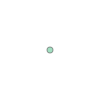

In [11]:
#Utilizando a função POINT da biblioteca shapely.geometry podemos criar um ponto:
latitude = -23.56 
longitude = -46.59
Point(longitude, latitude)

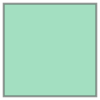

In [12]:
#Utilizando a função POLIGON da bilbioteca shapely.geometry podemos criar uma área:
Polygon([[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]])

In [13]:
#Agora, usando o método CONTAIN, podemos ver se o ponto(casa) está dentro do polígono(região censitária)
Polygon([[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]]).contains(Point(0.1,0.9))

True

In [67]:
#Aonde está a ALURA nesse banco de dados?
setor_censo_SP = setor_censitario[setor_censitario.NM_MUNICIP == "SÃO PAULO"]
setor_censo_SP[setor_censo_SP.contains(Point(-46.63,-23.58))]
#Vila Mariana!

,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry
60986,126568.0,355030890000080,URBANO,35503089000,None,355030890,VILA MARIANA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,60987,"POLYGON ((-46.62618 -23.58169, -46.62863 -23.5..."


In [15]:
DF_vendas_geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8500 entries, 0 to 89735
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rua          5626 non-null   object 
 1   Bairro       8492 non-null   object 
 2   Cidade       8500 non-null   object 
 3   Metragem     8500 non-null   int64  
 4   Quartos      8500 non-null   int64  
 5   Banheiros    8500 non-null   int64  
 6   Vagas        8500 non-null   int64  
 7   Valor_Bruto  8500 non-null   float64
 8   Valor_M2     8500 non-null   float64
 9   Apenas_Ruas  5626 non-null   object 
 10  rua          5626 non-null   object 
 11  cep          8500 non-null   float64
 12  latitude     8500 non-null   float64
 13  longitude    8500 non-null   float64
dtypes: float64(5), int64(4), object(5)
memory usage: 996.1+ KB


In [16]:
DF_vendas_geo["Ponto"] = ""
for i in DF_vendas_geo.index:
    DF_vendas_geo["Ponto"][i] = Point(DF_vendas_geo["longitude"][i],DF_vendas_geo["latitude"][i])

C:\Users\User\AppData\Local\Temp\ipykernel_8972\1738655671.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_vendas_geo["Ponto"][i] = Point(DF_vendas_geo["longitude"][i],DF_vendas_geo["latitude"][i])


In [17]:
DF_vendas_geo["Set_Censo"] = DF_vendas_geo["Ponto"].map(
    lambda x: setor_censo_SP.loc[setor_censo_SP.contains(x), 'CD_GEOCODI'].values).str[0]

DF_vendas_geo

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor_Bruto,Valor_M2,Apenas_Ruas,rua,cep,latitude,longitude,Ponto,Set_Censo
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,7000000.0,7000.000000,avenida itacira,avenida itacira,11443160.0,-23.975993,-46.201317,POINT (-46.2013172 -23.975993),NaN
5,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,3700000.0,7459.677419,rua aurelia perez alvarez,rua aurelia perez alvarez,4642020.0,-23.640961,-46.688311,POINT (-46.6883114 -23.6409612),355030871000023
6,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,380000.0,3040.000000,rua alba valdez,rua alba valdez,4845200.0,-23.752990,-46.695889,POINT (-46.6958895 -23.75299),355030830000050
7,NaN,Jardim Morumbi,São Paulo,310,3,2,4,685000.0,2209.677419,NaN,NaN,18125000.0,-23.531043,-47.255023,POINT (-47.2550228 -23.5310431),NaN
26,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,540000.0,5400.000000,rua tobias barreto,rua tobias barreto,13474663.0,-22.698901,-47.294461,POINT (-47.2944609 -22.6989009),NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89714,Avenida Odila,Planalto Paulista,São Paulo,267,3,6,4,1500000.0,5617.977528,avenida odila,avenida odila,4058020.0,-23.609093,-46.647258,POINT (-46.6472577 -23.6090928),355030877000099
89716,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,665000.0,7000.000000,rua tapuçu,rua tapuçu,4671185.0,-23.661018,-46.691521,POINT (-46.6915206 -23.661018),355030816000087
89717,Rua Guararema,Bosque da Saúde,São Paulo,605,8,7,5,2300000.0,3801.652893,rua guararema,rua guararema,13030640.0,-22.922749,-47.076960,POINT (-47.0769595 -22.9227492),NaN
89734,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,1050000.0,5121.951220,rua estero belaco,rua estero belaco,4145020.0,-23.616124,-46.632983,POINT (-46.632983 -23.6161237),355030877000052


<p>Mesmo fazendo da mesma forma que o professor fez na aula, alguns locais continuam obtendo NaN's, porém no arquivo CSV eles não ocorrem. Talvez ele tenha esquecido alguma coisa ou algo do gênero, de qualquer forma irei utilizar o arquivo csv disponibilizado a partir de agora.</p>

In [18]:
path_dados_geo = 'dados_geo.csv'
dados_geo = pd.read_csv(path_dados_geo)

In [19]:
dados_geo.drop(["Valor","Tipo_anuncio"],axis=1,inplace=True)
dados_geo

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor_anuncio,Valor_mm,Valor_m2,rua,cep,latitude,longitude,Point,setor_censo
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,7000000.0,7.000,7000.000000,Avenida Itacira,4061000.0,-23.615793,-46.648162,POINT (-46.6481622 -23.6157934),3.550309e+14
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,3700000.0,3.700,7459.677419,Rua Aurelia Perez Alvarez,4642020.0,-23.640961,-46.688311,POINT (-46.6883114 -23.6409612),3.550309e+14
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,380000.0,0.380,3040.000000,Rua Alba Valdez,4845200.0,-23.752990,-46.695889,POINT (-46.6958895 -23.75299),3.550308e+14
3,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,540000.0,0.540,5400.000000,Rua Tobias Barreto,3176000.0,-23.549960,-46.588173,POINT (-46.5881729 -23.5499597),3.550308e+14
4,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,1980000.0,1.980,4500.000000,Rua Graham Bell,4737030.0,-23.593796,-46.760077,POINT (-46.7600773 -23.5937964),3.550309e+14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5600,Avenida Odila,Planalto Paulista,São Paulo,267,3,6,4,1500000.0,1.500,5617.977528,Avenida Odila,4058020.0,-23.609093,-46.647258,POINT (-46.6472577 -23.6090928),3.550309e+14
5601,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,665000.0,0.665,7000.000000,Rua Tapuçu,4671185.0,-23.661018,-46.691521,POINT (-46.6915206 -23.661018),3.550308e+14
5602,Rua Guararema,Bosque da Saúde,São Paulo,605,8,7,5,2300000.0,2.300,3801.652893,Rua Guararema,4136030.0,-23.411688,-46.037387,POINT (-46.0373872 -23.411688),NaN
5603,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,1050000.0,1.050,5121.951220,Rua Estero Belaco,4145020.0,-23.616124,-46.632983,POINT (-46.632983 -23.6161237),3.550309e+14


In [147]:
#Vinculo os dados geográficos com os dados do IBGE
dados_vendas_censo = pd.merge(left = dados_geo, right = DF_IBGE_or, how = "left", left_on = "setor_censo", 
                              right_on = "Cod_setor")

#Fazemos uma limpeza rápida dos dados
dados_vendas_censo.drop("Unnamed: 33", axis=1, inplace=True)

#Retiro qualquer setor censitário que tenha retornado nulo.
dados_vendas_censo = dados_vendas_censo[dados_vendas_censo["setor_censo"].notnull()]

#Retiro qualquer metragem acima de 5 mil.
dados_vendas_censo = dados_vendas_censo[dados_vendas_censo["Metragem"]<5000]

dados_vendas_censo["Index"] = dados_vendas_censo.index
bruim = bairros_ruins(dados_vendas_censo,CASAS=1)
dados_vendas_censo = dados_vendas_censo.set_index("Bairro").drop(bruim)
dados_vendas_censo.set_index("Index")

,Rua,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor_anuncio,Valor_mm,Valor_m2,rua,...,V003,V004,V005,V006,V007,V008,V009,V010,V011,V012
Index,,,,,,,,,,,,,,,,,,,,,
0,"Avenida Itacira, 255",São Paulo,1000,4,8,6,7000000.0,7.000,7000.000000,Avenida Itacira,...,2.66,2.04,3158.96,22210644.93,5570.65,25770816.97,2096.19,13029851.56,3930.35,17241576.74
1,"Rua Aurelia Perez Alvarez, 42",São Paulo,496,4,4,4,3700000.0,3.700,7459.677419,Rua Aurelia Perez Alvarez,...,3.13,1.96,7600.44,36778930.17,7890.53,35886906.64,4149.00,26760682.90,6063.92,27502674.90
3,"Rua Tobias Barreto, 195",São Paulo,100,3,2,2,540000.0,0.540,5400.000000,Rua Tobias Barreto,...,3.00,1.99,2338.05,7826370.15,2447.89,7925839.76,1543.29,4646566.16,1909.04,5050712.69
4,Rua Graham Bell,São Paulo,440,4,4,6,1980000.0,1.980,4500.000000,Rua Graham Bell,...,3.51,2.31,1026.36,272168.67,1143.96,167733.64,735.67,367088.08,1086.94,159622.46
5,"Rua Francisco Paulo, 31",São Paulo,145,4,4,2,850000.0,0.850,5862.068966,Rua Francisco Paulo,...,2.95,2.18,1580.84,4440789.58,1897.01,4730743.23,1284.45,2578384.56,1743.39,2699812.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5599,Rua Pedro Teixeira,São Paulo,157,3,2,2,960000.0,0.960,6114.649682,Rua Pedro Teixeira,...,2.17,1.27,5054.58,33245189.73,5231.93,33485189.78,3649.06,26562232.53,4551.66,29032823.35
5600,Avenida Odila,São Paulo,267,3,6,4,1500000.0,1.500,5617.977528,Avenida Odila,...,2.81,1.60,4249.33,24499871.44,5180.14,25047413.33,2618.76,17705032.31,3977.93,21495997.85
5601,Rua Tapuçu,São Paulo,95,2,2,2,665000.0,0.665,7000.000000,Rua Tapuçu,...,2.99,1.81,2425.09,6878872.25,2543.80,6913867.79,1561.58,4261814.01,2062.09,4596759.57


<AxesSubplot:xlabel='Situacao_setor', ylabel='Metragem'>

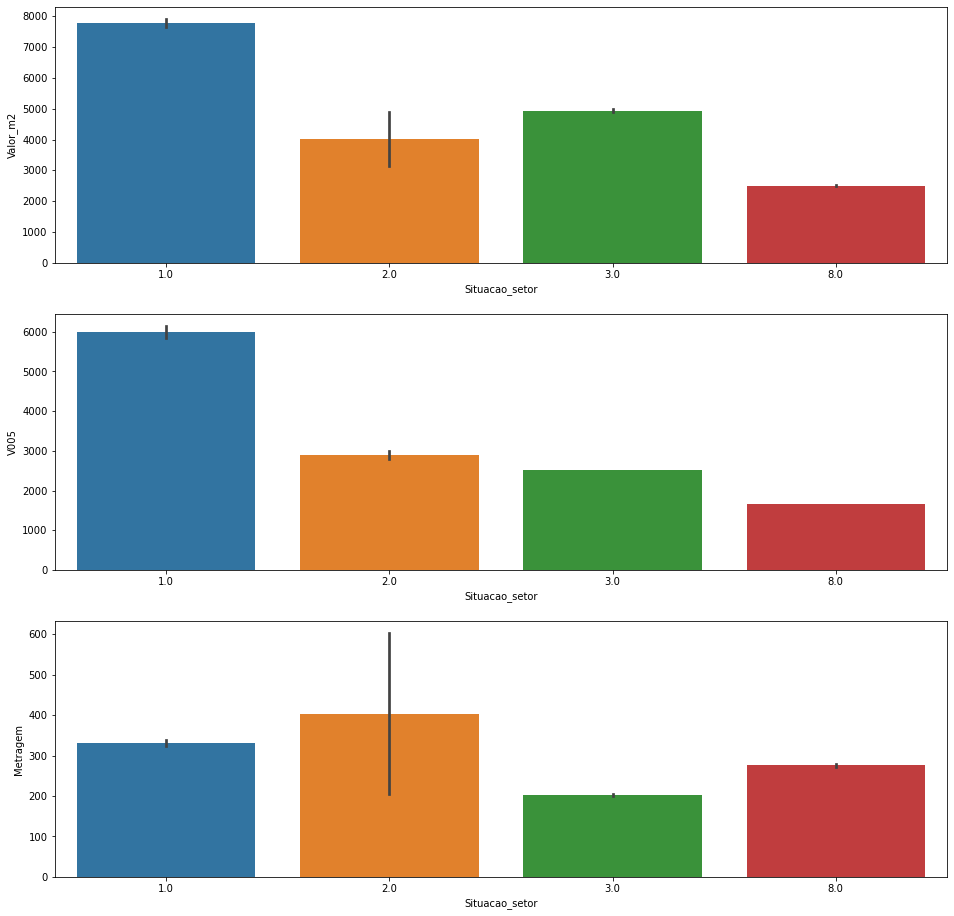

In [153]:
fonte = {'size':15}
fig, axes = plt.subplots(3, figsize = (16,16))
sns.barplot(data=dados_vendas_censo,x="Situacao_setor",y="Valor_m2", ax = axes[0])
sns.barplot(data=dados_vendas_censo,x="Situacao_setor",y="V005", ax = axes[1])
sns.barplot(data=dados_vendas_censo, x="Situacao_setor", y="Metragem", ax=axes[2])

<p>Podemos ver que setor urbanizados (1) apresentam uma renda média maior do que setores de áreas não-urbanizadas (2) ou áreas urbanas isoladas (3). Esse fato reflete no valor do metro quadrado desses setores. Zonas rurais são mais isoladas (tendo menos empregos/empresas) e portanto apresentam uma menor renda mensal e um preço por m² também mais baixo.</p>

<p>Por outro lado, podemos ver que regiões urbanizadas tendem a vender casas menores que regiões não-urbanizadas.</p>

<p>Um ponto a levar em consideração a respeito da metragem de regiões rurais é que ao limparmos a metragem dos dados, um dado com uma metragem de mais de 35mil foi retirado. Esse dado seria incluido em uma região rural, portanto ele me leva a acreditar que é uma fazenda ou um lote de terra para plantio que esteja a venda.</p>

<p>Como podemos ver, existe uma única casa que pertence a esse setor e isso indica que não é possível fazermos uma média desse valor para a análise, portanto iremos jogá-lo fora.</p>

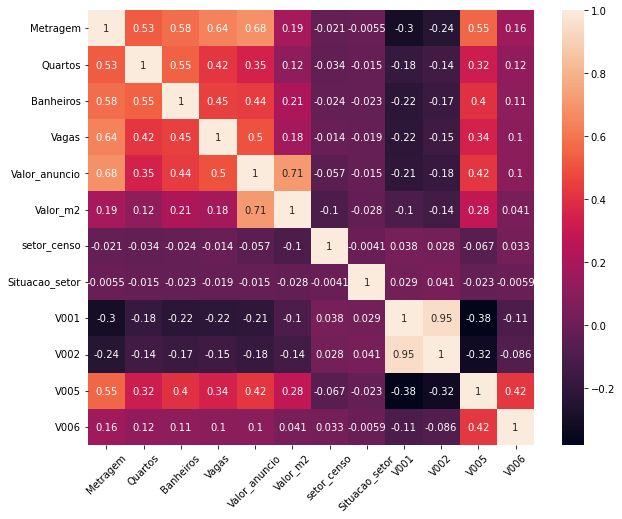

In [162]:
#Agora, analiso a correlação entre diversas variáveis:
lista=["Rua","Metragem","Quartos","Banheiros","Vagas","Valor_anuncio","Valor_m2","setor_censo","Situacao_setor","V001",
      "V002","V005","V006"]
plt.figure(figsize=(10,8))
ax = sns.heatmap(dados_vendas_censo[lista].corr(), annot=True)
ax.tick_params(axis='x',rotation=45)